<a href="https://colab.research.google.com/github/RakiAbhistaPrakoso/VisiKomputer---Raki-Abhista-Prakoso/blob/main/Praktikum3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**D1 - Praktikum 3**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# === Generator 1 sample ===
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y

    # Gambar lingkaran putih terisi
    cv2.circle(img, (cx, cy), r, (255,), -1)

    # Normalisasi ke 0–1 dan ubah ke float32
    img = (img / 255.0).astype(np.float32)

    # Jadikan 3-channel agar kompatibel dengan CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)


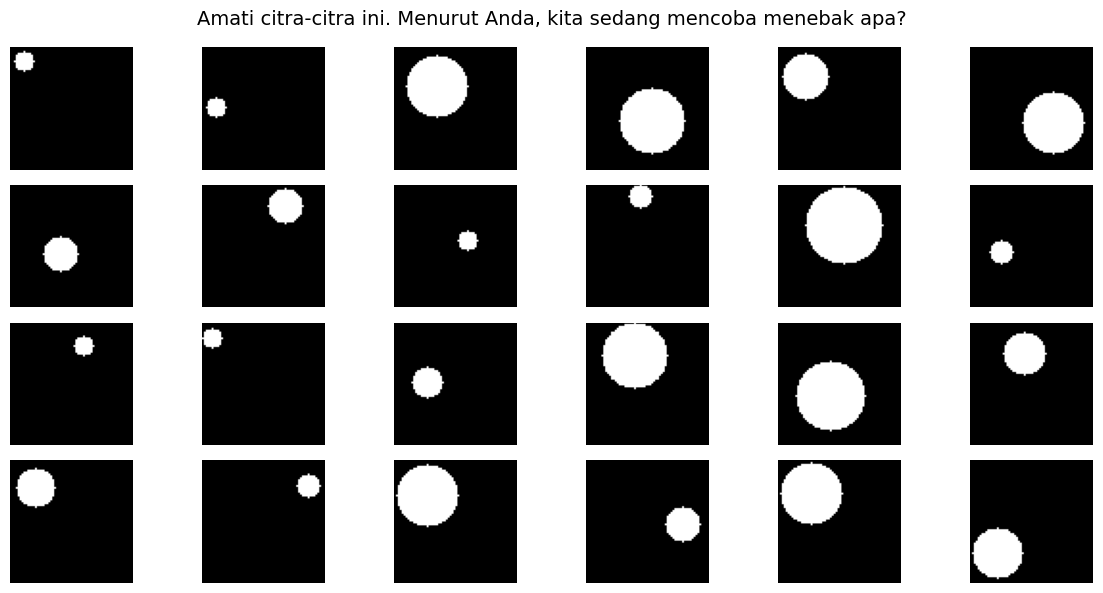

In [ ]:
# === Buat 24 contoh untuk visualisasi ===
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# === Grid gambar tanpa label ===
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=14)
plt.tight_layout()
plt.show()

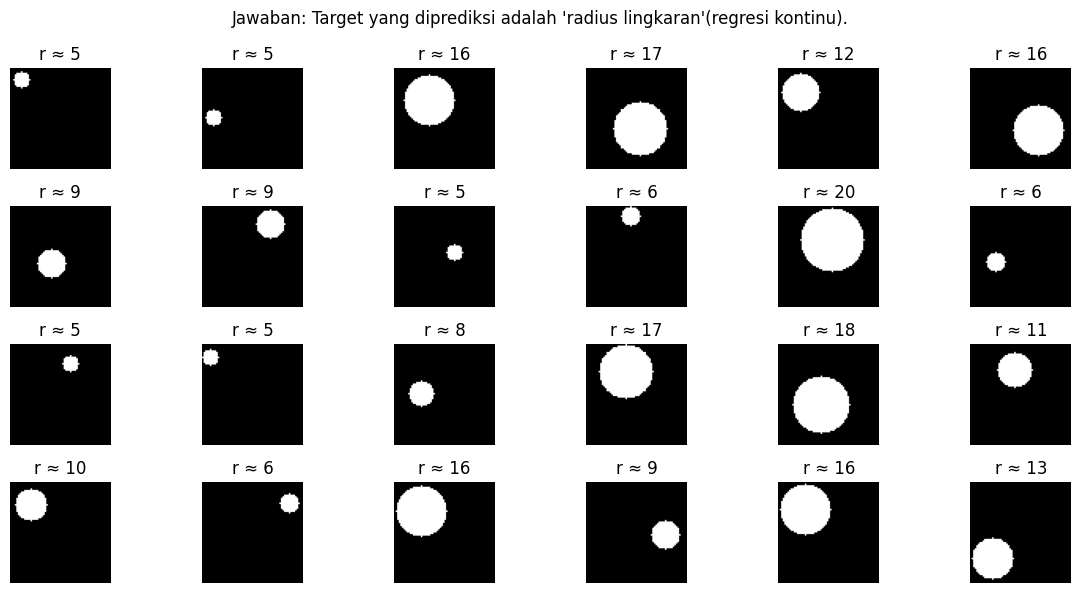

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
      plt.subplot(rows, cols, i+1)
      plt.imshow(imgs[i].squeeze(), cmap='gray')
      plt.title(f"r ≈ {int(rads[i])}")
      plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran'(regresi kontinu).")
plt.tight_layout()
plt.show()

In [ ]:
# === Siapkan dataset lebih besar untuk training ===
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# === Model CNN sederhana ===
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# === Evaluasi ===
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
MAE=0.932 | RMSE=1.184 | R2=0.934


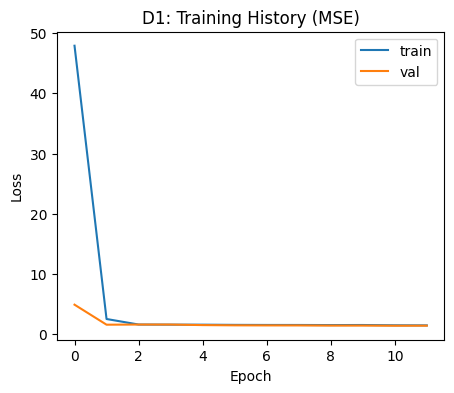

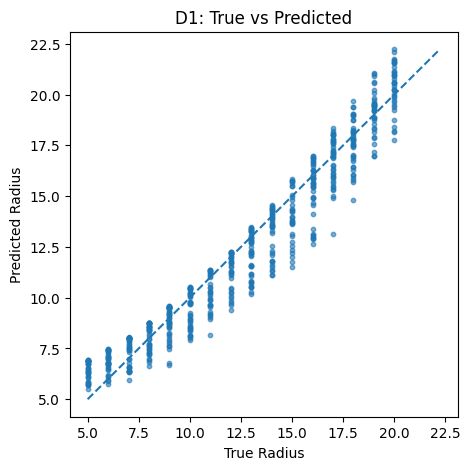

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

**D2 - Praktikum 3**

In [15]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rakiabhistaprakosoti","key":"0ead592c1401be119d3b03209496e2d6"}'}

In [16]:
import os, shutil
if os.path.exists("kaggle.json"):
      os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
      shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
      os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
      !pip -q install kaggle
      print("✅ Kaggle API siap digunakan.")
else:
      print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [17]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


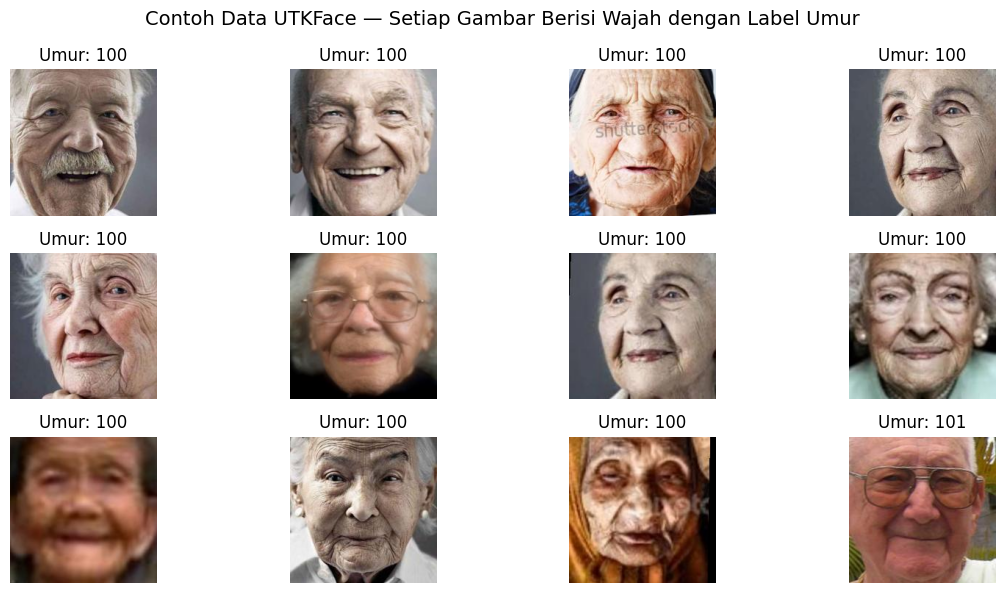

In [18]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
      # Ambil umur dari nama file
      age = int(os.path.basename(f).split("_")[0])
      img = Image.open(f)
      plt.subplot(3, 4, i + 1)
      plt.imshow(img)
      plt.title(f"Umur: {age}")
      plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
def parse_age_from_name(fp):
      return int(os.path.basename(fp).split('_')[0])
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
      img = tf.io.read_file(fp)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
      return img / 255.0, label
train_ds = tf.data.Dataset.from_tensor_slices((train_files,y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 57s 133ms/step - loss: 354.5807 - mae: 13.8561 - val_loss: 160.7411 - val_mae: 9.6506 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - loss: 159.5553 - mae: 9.4274 - val_loss: 147.3300 - val_mae: 9.1038 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 144.4645 - mae: 8.8447 - val_loss: 142.6042 - val_mae: 8.9177 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 142.1500 - mae: 8.7939 - val_loss: 141.7983 - val_mae: 8.8995 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 139.9329 - mae: 8.6669 - val_loss: 142.4722 - val_mae: 8.9435 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 136.9590 - mae: 8.5923 - val_loss: 137.2228 - val_mae: 8.6722 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 135.7920 - mae: 8.5133 - val_loss: 135.1714 - va

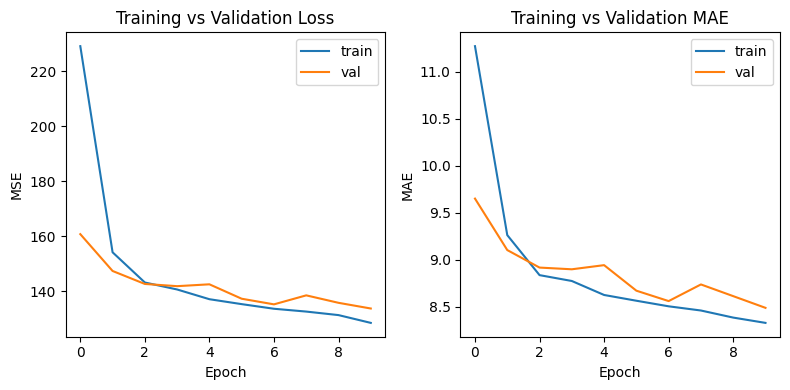

In [21]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 48s 103ms/step - loss: 193.9812 - mae: 10.2567 - val_loss: 149.9073 - val_mae: 8.9963 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 80.2625 - mae: 6.6218 - val_loss: 126.2395 - val_mae: 8.4174 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 53.2478 - mae: 5.4429 - val_loss: 111.1723 - val_mae: 7.8113 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 38.7171 - mae: 4.6804 - val_loss: 102.4894 - val_mae: 7.4740 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 29.8495 - mae: 4.1435 - val_loss: 105.7334 - val_mae: 7.4817 - learning_rate: 1.0000e-04


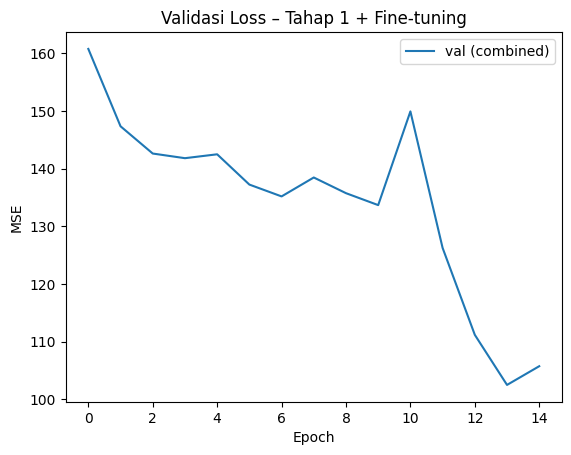

In [22]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(
    history.history['val_loss'] + history_ft.history['val_loss'],
    label='val (combined)'
)
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE = 7.47 tahun
RMSE = 10.12 tahun
R2 = 0.742


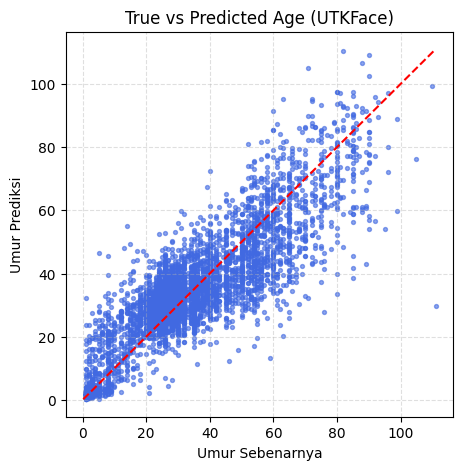

In [23]:
from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")
# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

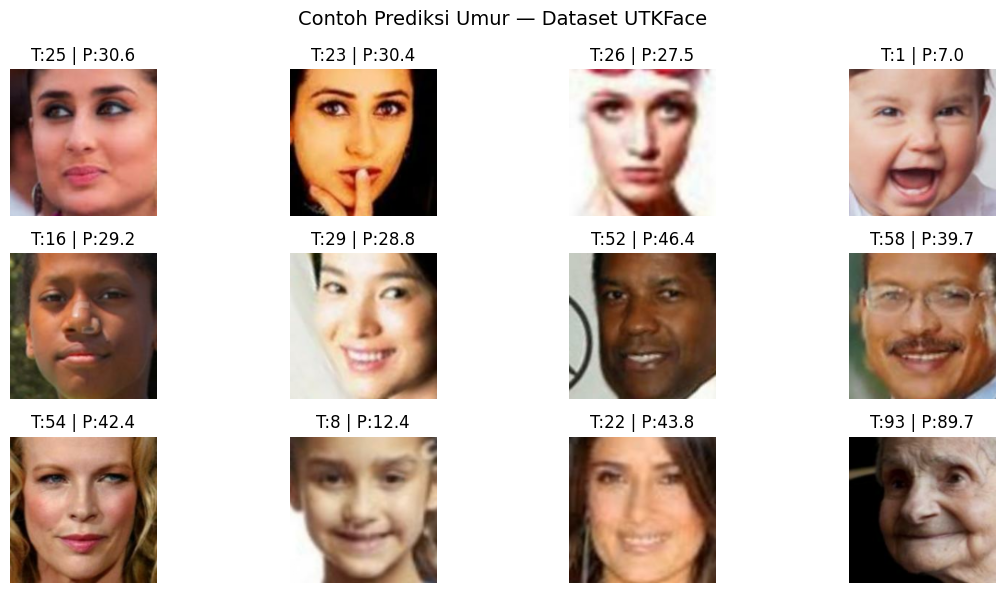

In [24]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
      img = tf.io.read_file(path)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
      true_age = int(os.path.basename(path).split('_')[0])
      pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
      plt.subplot(3,4,i+1)
      plt.imshow(img.numpy())
      plt.title(f"T:{true_age} | P:{pred_age:.1f}")
      plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

**D3 - Praktikum 3**

In [1]:
from google.colab import files
import os, shutil

# Upload file kaggle.json dari komputer
files.upload()

# Konfigurasi API
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("⚠️ File kaggle.json belum diupload.")

Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


In [7]:
# Pastikan sudah join kompetisi: https://www.kaggle.com/competitions/petfinder-pawpularity-score/data
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


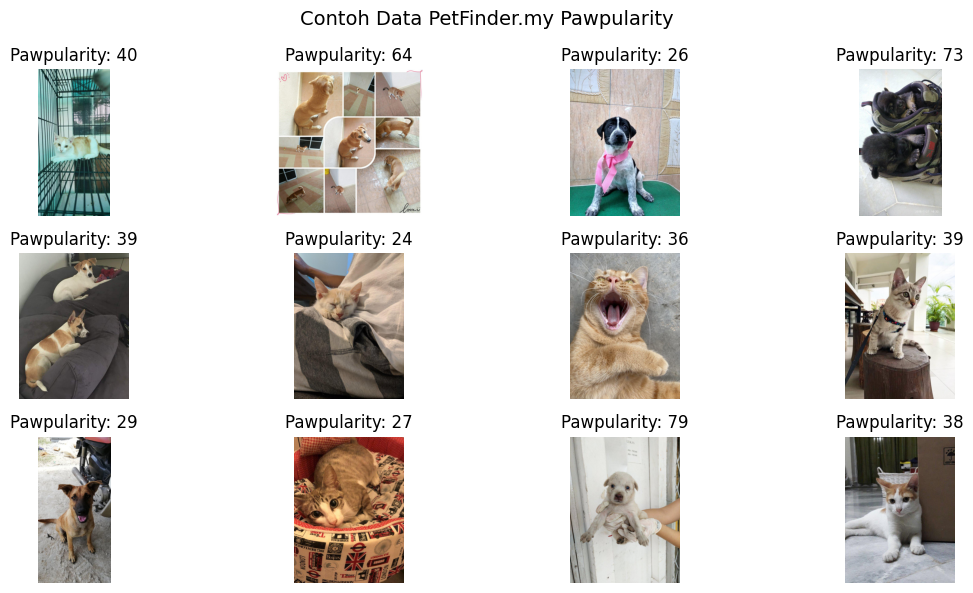

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Baca file CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12,6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} training, {len(val_df)} validasi.")


Dataset siap digunakan — 7929 training, 1983 validasi.


In [10]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # Bekukan bobot awal

# Tambahkan head regresi
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 111s 525ms/step - loss: 817.6541 - mae: 21.5488 - val_loss: 474.8598 - val_mae: 15.9866 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - loss: 433.8790 - mae: 15.3764 - val_loss: 430.9490 - val_mae: 15.0504 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - loss: 385.7643 - mae: 14.4788 - val_loss: 406.0493 - val_mae: 14.9387 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - loss: 364.8149 - mae: 14.2022 - val_loss: 395.5723 - val_mae: 14.5634 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 215ms/step - loss: 357.0064 - mae: 14.0290 - val_loss: 384.0858 - val_mae: 14.4370 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - loss: 354.8400 - mae: 14.0095 - val_loss: 382.2054 - val_mae: 14.2010 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - loss: 354.6791 - mae: 13.8942 - val_

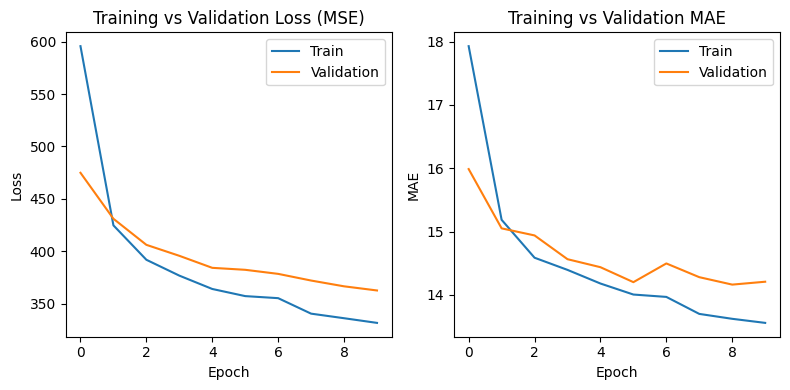

In [12]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()


MAE  = 14.21
RMSE = 19.04
R²   = 0.180


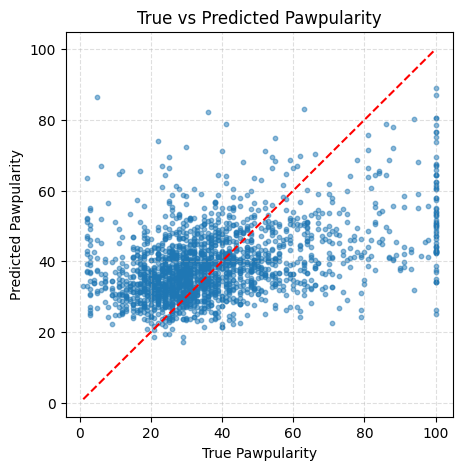

In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


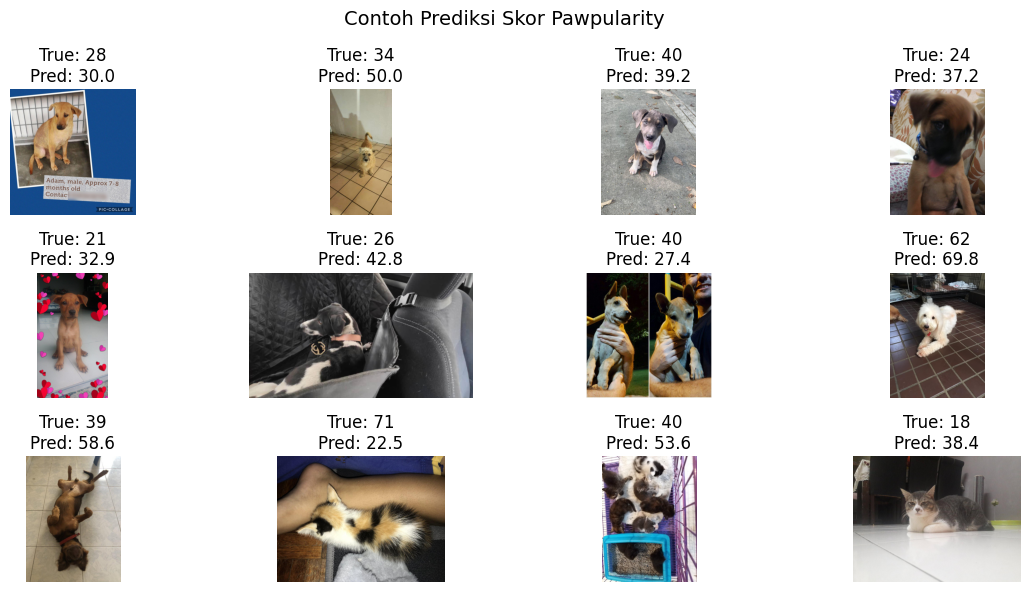

In [14]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Penugasan - Foto Sendiri Usia

In [37]:
from google.colab import files
uploaded = files.upload()  # pilih foto kamu, misal "aku.jpg"

Saving Raki.jpg to Raki (2).jpg


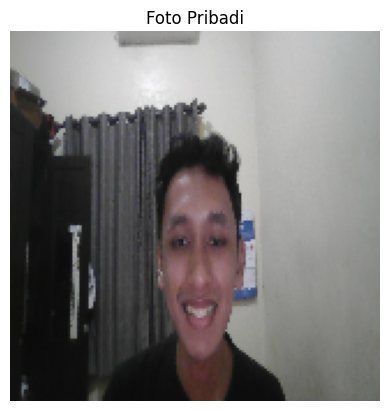

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 160  # ukuran model UTKFace
img_path = list(uploaded.keys())[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

plt.imshow(img.numpy())
plt.axis('off')
plt.title("Foto Pribadi")
plt.show()

In [36]:
pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
print(f"Perkiraan umur dari model: {pred_age:.1f} tahun")

Perkiraan umur dari model: 13.1 tahun


Penugasan Foto Peliharaan Sendiri

In [31]:
from google.colab import files
uploaded = files.upload()  # contoh: "kucingku.jpg"

Saving Kucing.jpg to Kucing.jpg


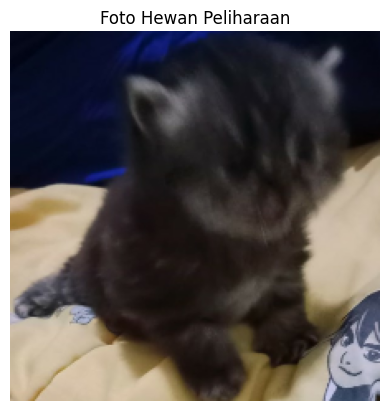

In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 224
img_path = list(uploaded.keys())[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

plt.imshow(img.numpy())
plt.axis('off')
plt.title("Foto Hewan Peliharaan")
plt.show()

In [33]:
pred_score = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
print(f"Perkiraan skor Pawpularity: {pred_score:.1f}/100")

Perkiraan skor Pawpularity: 26.4/100
